In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_1dm as iefc
from wfsc import utils

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


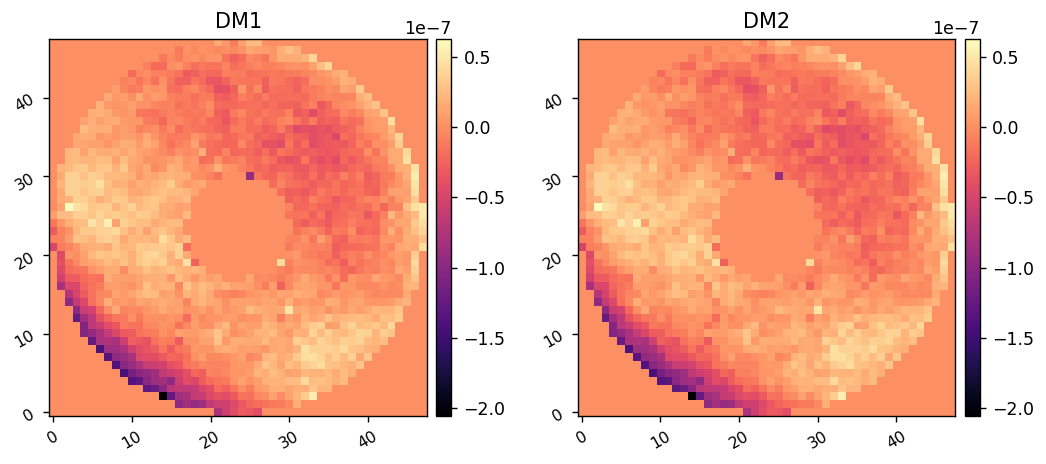

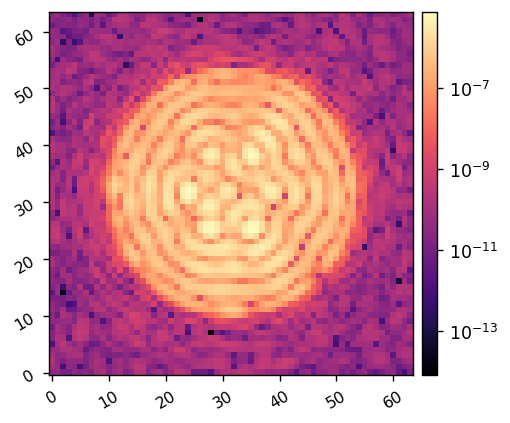

In [3]:
reload(cgi)
sys = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sys.show_dms()

npsf = sys.npsf
Nact = sys.Nact

ref_psf = sys.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

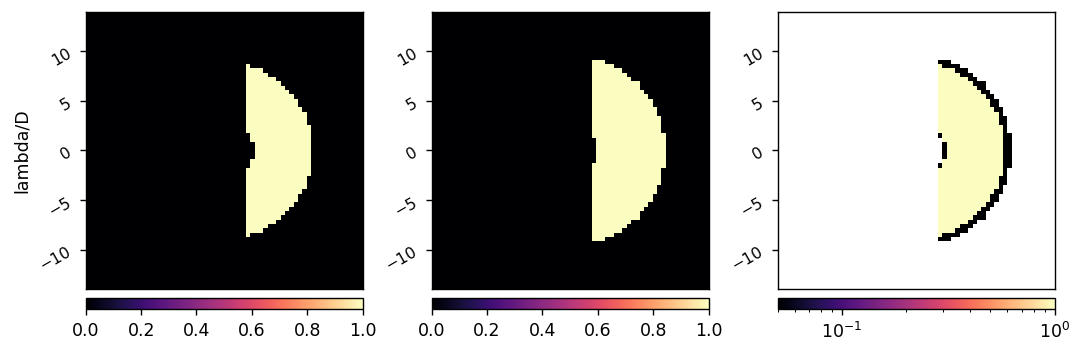

In [4]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
#     'direction' : '+x',
    'rotation':rot,
    'full':False
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
#     'direction' : '+x',
    'rotation':rot,
    'full':False
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.95

weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask 
misc.myimshow3(dh_mask.reshape(npsf,npsf),
               control_mask.reshape(npsf,npsf), 
               weights.reshape(npsf,npsf),
               lognorm3=True,
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD, pxscl3=sys.psf_pixelscale_lamD)


# Create probe and fourier modes

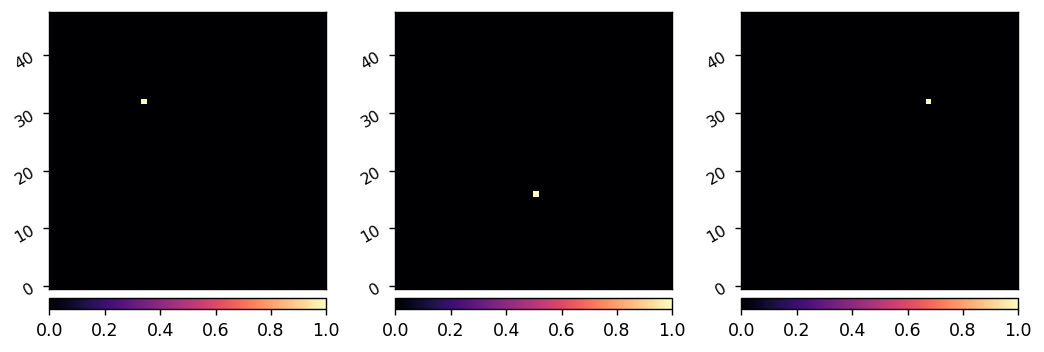

Creating Fourier modes:  (64, 64)
Calibration modes required: 228


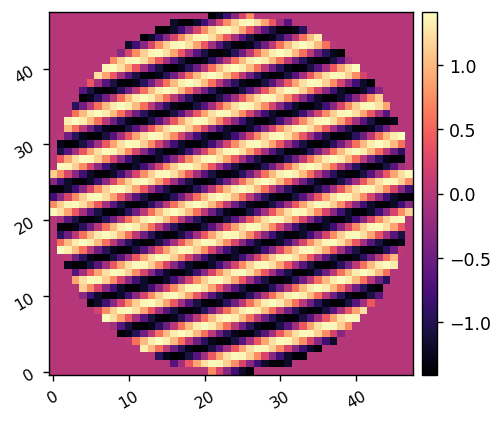

In [5]:
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//3, Nact//2, 2*Nact//3],
                                           yinds=[2*Nact//3, Nact//3, 2*Nact//3],
                                           display=True)

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= sys.dm_mask.flatten()


calibration_amplitude = 0.006 * sys.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * sys.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow(calibration_modes[0].reshape(Nact,Nact))

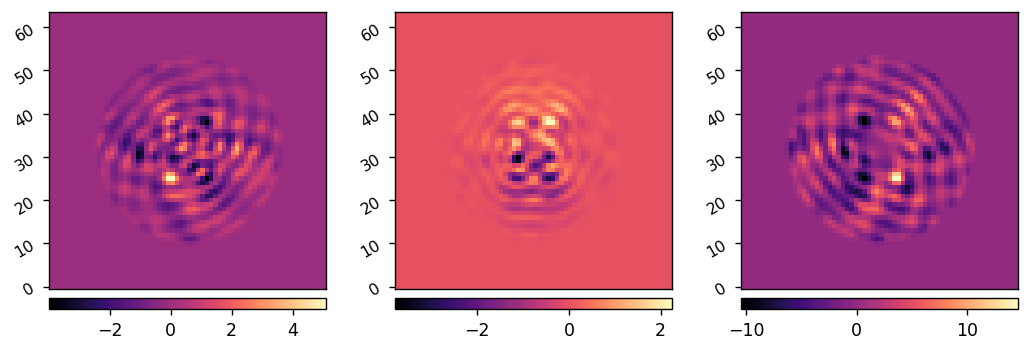

In [6]:
reload(iefc)
sys.reset_dms()
differential_images, single_images = iefc.take_measurement(sys, probe_modes, probe_amplitude, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [11]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(sys, 
                                                 probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, 
                                                 start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 228 in 3.806s
	Calibrated mode 2 / 228 in 7.596s
	Calibrated mode 3 / 228 in 11.384s
	Calibrated mode 4 / 228 in 15.175s
	Calibrated mode 5 / 228 in 19.148s
	Calibrated mode 6 / 228 in 22.934s
	Calibrated mode 7 / 228 in 26.718s
	Calibrated mode 8 / 228 in 30.504s
	Calibrated mode 9 / 228 in 34.293s
	Calibrated mode 10 / 228 in 38.077s
	Calibrated mode 11 / 228 in 41.866s
	Calibrated mode 12 / 228 in 45.651s
	Calibrated mode 13 / 228 in 49.442s
	Calibrated mode 14 / 228 in 53.366s
	Calibrated mode 15 / 228 in 57.151s
	Calibrated mode 16 / 228 in 60.932s
	Calibrated mode 17 / 228 in 64.713s
	Calibrated mode 18 / 228 in 68.493s
	Calibrated mode 19 / 228 in 72.275s
	Calibrated mode 20 / 228 in 76.065s
	Calibrated mode 21 / 228 in 79.858s
	Calibrated mode 22 / 228 in 83.646s
	Calibrated mode 23 / 228 in 87.574s
	Calibrated mode 24 / 228 in 91.348s
	Calibrated mode 25 / 228 in 95.123s
	Calibrated mode 26 / 228 in 98.899s
	Calibrated mode 27 / 228 in

	Calibrated mode 215 / 228 in 817.546s
	Calibrated mode 216 / 228 in 821.323s
	Calibrated mode 217 / 228 in 825.101s
	Calibrated mode 218 / 228 in 829.010s
	Calibrated mode 219 / 228 in 832.791s
	Calibrated mode 220 / 228 in 836.577s
	Calibrated mode 221 / 228 in 840.361s
	Calibrated mode 222 / 228 in 844.147s
	Calibrated mode 223 / 228 in 847.927s
	Calibrated mode 224 / 228 in 851.705s
	Calibrated mode 225 / 228 in 855.492s
	Calibrated mode 226 / 228 in 859.276s
	Calibrated mode 227 / 228 in 863.191s
	Calibrated mode 228 / 228 in 866.991s
Calibration complete.


In [17]:
iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
fname = 'hlc_opds_flatmaps_39'


In [75]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_opds_flatmaps_39
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/hlc_opds_flatmaps_39


In [18]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

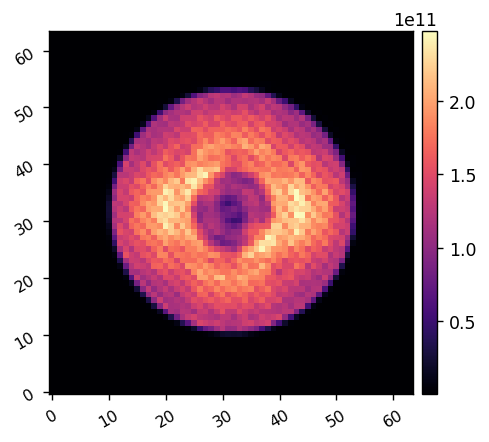

In [19]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [10]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), 
                                               rcond=1e-2, 
                                               nprobes=probe_modes.shape[0], pca_modes=None)

Using Weighted Least Squares 


# Run IEFC

In [12]:
reload(iefc)
sys.reset_dms()
images, dm_commands = iefc.run(sys, 
                               control_matrix, 
                               probe_modes, 
                               probe_amplitude, 
                               calibration_modes, 
                               weights, 
                               num_iterations=15, gain=-0.5, leakage=0.0,
                               display=True)

Running I-EFC...
	Closed-loop iteration 1 / 15


ValueError: shapes (2304,228) and (296,) not aligned: 228 (dim 1) != 296 (dim 0)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
